In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib
#matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
 
width = 0.75
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.axis('off')
from nltk.corpus import stopwords
from textblob import TextBlob
import scattertext as st
import spacy
import spacy_cld

from IPython.display import IFrame
from IPython.core.display import display, HTML
from collections import Counter
from tqdm import tqdm_notebook as tqdm  # cool progress bars
tqdm().pandas() 

In [2]:
tweets = pd.read_csv('small.csv',encoding='utf-8')
print(tweets.shape)
tweets.head()


(5349, 7)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [3]:
first_inbound = tweets[pd.isnull(tweets.in_response_to_tweet_id) & tweets.inbound]

QnR = pd.merge(first_inbound, tweets, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')

# Filter to only outbound replies (from companies)
QnR = QnR[QnR.inbound_y ^ True]
print(f'Data shape: {QnR.shape}')
QnR.head()

Data shape: (1283, 14)


,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
0,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
1,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,NaN,17,sprintcare,False,Tue Oct 31 19:59:13 +0000 2017,@115713 H there! We'd definitely like to work ...,16,18.0
2,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,NaN,19,sprintcare,False,Tue Oct 31 22:10:10 +0000 2017,@115715 Please send me a private message so th...,NaN,20.0
3,29,115716,True,Tue Oct 31 22:01:35 +0000 2017,actually that's a broken link you sent me and ...,28,NaN,28,Ask_Spectrum,False,Tue Oct 31 22:05:37 +0000 2017,@115716 The information pertaining to the acco...,24,29.0
4,31,115717,True,Tue Oct 31 22:06:54 +0000 2017,"Yo @Ask_Spectrum, your customer service reps a...",30,NaN,30,Ask_Spectrum,False,Tue Oct 31 22:12:09 +0000 2017,"@115717 Hello, My apologies for any frustratio...",NaN,31.0


In [4]:
def sn_replace(match):
    _sn = match.group(2).lower()
    if not _sn.isnumeric():
        # This is a company screen name
        return match.group(1) + match.group(2)
    return ''
    
sn_re = re.compile('(\W@|^@)([a-zA-Z0-9_]+)')
print("Removing anonymized screen names in X...")
QnR["text_x"] = QnR.text_x.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))
print("Removing anonymized screen names in Y...")
QnR["text_y"] = QnR.text_y.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))

Removing anonymized screen names in X...



Removing anonymized screen names in Y...


In [5]:
QnR = QnR[["author_id_x","created_at_x","text_x","author_id_y","created_at_y","text_y"]]
QnR.head(5)

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y
0,115712,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:24 +0000 2017,"Can you please send us a private message, so ..."
1,115713,Tue Oct 31 19:56:01 +0000 2017,y’all lie about your “great” connection. 5 ba...,sprintcare,Tue Oct 31 19:59:13 +0000 2017,H there! We'd definitely like to work with yo...
2,115715,Tue Oct 31 22:03:34 +0000 2017,"whenever I contact customer support, they tel...",sprintcare,Tue Oct 31 22:10:10 +0000 2017,Please send me a private message so that I ca...
3,115716,Tue Oct 31 22:01:35 +0000 2017,actually that's a broken link you sent me and ...,Ask_Spectrum,Tue Oct 31 22:05:37 +0000 2017,The information pertaining to the account ass...
4,115717,Tue Oct 31 22:06:54 +0000 2017,"Yo @Ask_Spectrum, your customer service reps a...",Ask_Spectrum,Tue Oct 31 22:12:09 +0000 2017,"Hello, My apologies for any frustrations or i..."


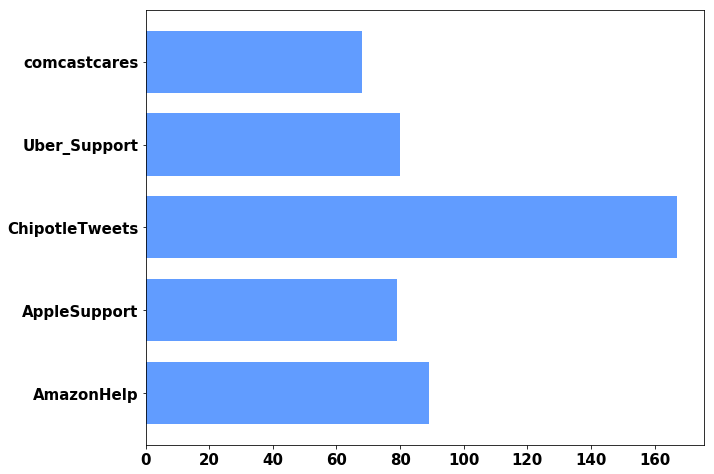

In [6]:
count = QnR.groupby("author_id_y")["text_x"].count()
c = count[count>50].plot(kind='barh',figsize=(10, 8), color='#619CFF', zorder=2, width=width,)
c.set_ylabel('')
plt.show()

In [8]:
amazonQnR = QnR[QnR["author_id_y"]=="AmazonHelp"]

In [7]:
amazonQnR = QnR[QnR["author_id_y"]=="AmazonHelp"]

In [8]:
nlp_cld = spacy.load('en_core_web_sm',disable_pipes=["tagger","ner"])
language_detector = spacy_cld.LanguageDetector()
nlp_cld.add_pipe(language_detector)

In [9]:
doc = nlp_cld(amazonQnR.iloc[4]["text_x"])
print(doc)
print(doc._.languages)  
print(doc._.language_scores)

 also, beim Addams Family-Film in Prime sind Bild und Ton nicht wirklich synchron. Wie kommt's?
['de']
{'de': 0.98}


In [10]:
mask = []
try:
    for i,doc in tqdm(enumerate(nlp_cld.pipe(amazonQnR["text_x"], batch_size=512))):
            if 'en' not in doc._.languages or len(doc._.languages) != 1:
                mask.append(False)
            else:
                mask.append(True)
except Exception:
    print("excepted ")

In [11]:
amazonQnR = amazonQnR[mask]
# sample a random fraction to visually ensure that we have only English tweets
amazonQnR.sample(frac=0.0002)    

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y


In [12]:
amazonQnR.tail(10)["text_x"]

1035    Just had my first Prime Now delivery. 2 hours ...
1037    I have 2 echos and set up multi room music pla...
1038    @AmazonHelp Someone keeps trying to buy playst...
1041    @AmazonHelp live chat down in the UK and as a ...
1176     I have stopped ordering from your site, Amazo...
1177     I have stopped ordering from your site, Amazo...
1178    I go to watch #thebay and episode 7 &amp; 8 ar...
1179    I lost my signal while searching something in ...
1180     #HappyHalloween2017 from your biggest fan. Th...
1262     So for the 4th time the package I ordered was...
Name: text_x, dtype: object

In [13]:
nlp = spacy.load("en_core_web_sm",disable_pipes=["tagger"])

from spacymoji import Emoji
emoji = Emoji(nlp)
nlp.add_pipe(emoji, first=True)

In [14]:
print(nlp.pipe_names)

['emoji', 'tagger', 'parser', 'ner']


In [15]:
emojis = []
for doc in tqdm(nlp.pipe(amazonQnR["text_x"], batch_size=512)):
    if doc._.has_emoji:
        for e in doc._.emoji:
            emojis.extend(e[0])

In [16]:
eCount = Counter(emojis)
eCount.most_common(10)

[('😡', 5), ('😒', 5), ('😠', 3), ('👏', 2), ('😩', 1), ('💔', 1), ('😭', 1)]

In [17]:
response_emojis = []
for doc in tqdm(nlp.pipe(amazonQnR["text_y"], batch_size=512)):
    elist = []
    if doc._.has_emoji:
        for e in doc._.emoji:
            elist.append(e[0])
    response_emojis.append(elist)

In [18]:
Counter([item for sublist in response_emojis for item in sublist]).most_common(10)

[('🐶', 1)]

In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sent_analyser = SentimentIntensityAnalyzer()
positive_text = "love this phone! its the best one I've owned over the years"
negative_text = "what sort of company makes such products? this phone hangs up all the time and is totally useless"
print("positive_text sentiment : ",sent_analyser.polarity_scores(positive_text)["compound"])
print("negative_text sentiment : ",sent_analyser.polarity_scores(negative_text)["compound"])

positive_text sentiment :  0.8655
negative_text sentiment :  -0.4754


In [20]:
def sentiment(text):
    return (sent_analyser.polarity_scores(text)["compound"] + TextBlob(text).sentiment.polarity)/2
amazonQnR["text_x_sentiment"] = amazonQnR["text_x"].apply(sentiment)

In [21]:
response_emojis_for_positive_queries = []
response_emojis_for_negative_queries = []
for i,sentiment in enumerate(amazonQnR["text_x_sentiment"]):
    if sentiment > 0.0:
        response_emojis_for_positive_queries.extend(response_emojis[i])
    elif sentiment < 0.0:
        response_emojis_for_negative_queries.extend(response_emojis[i])

In [22]:
amazonQnR[amazonQnR["text_x_sentiment"]>0].head()

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,text_x_sentiment
78,115822,Tue Oct 31 22:19:34 +0000 2017,I want my amazon payments account CLOSED. dm...,AmazonHelp,Tue Oct 31 22:28:34 +0000 2017,I am unable to affect your account via Twitte...,0.205300
81,115829,Tue Oct 31 21:34:58 +0000 2017,my package was ‘accidentally’ opened.. 4 item...,AmazonHelp,Tue Oct 31 22:27:00 +0000 2017,I'm sorry your order arrived in this conditio...,0.392475
83,115832,Tue Oct 31 22:05:36 +0000 2017,"Thanks for the style advice, look ...I think? ...",AmazonHelp,Tue Oct 31 22:26:07 +0000 2017,Alexa says both styles are working for you! M...,0.320200
87,115838,Tue Oct 31 22:11:15 +0000 2017,@AmazonHelp Is it possible to prevent AMZL fro...,AmazonHelp,Tue Oct 31 22:24:47 +0000 2017,Oh no! We want to hear more about your experi...,0.012900
88,115839,Tue Oct 31 22:02:14 +0000 2017,", it’d be nice if the book I waited 4 months f...",AmazonHelp,Tue Oct 31 22:11:00 +0000 2017,I'm sorry your book arrived this way! You can...,0.287100


In [23]:
Counter(response_emojis_for_positive_queries).most_common(10)

[]

In [24]:
Counter(response_emojis_for_negative_queries).most_common(10)

[('🐶', 1)]

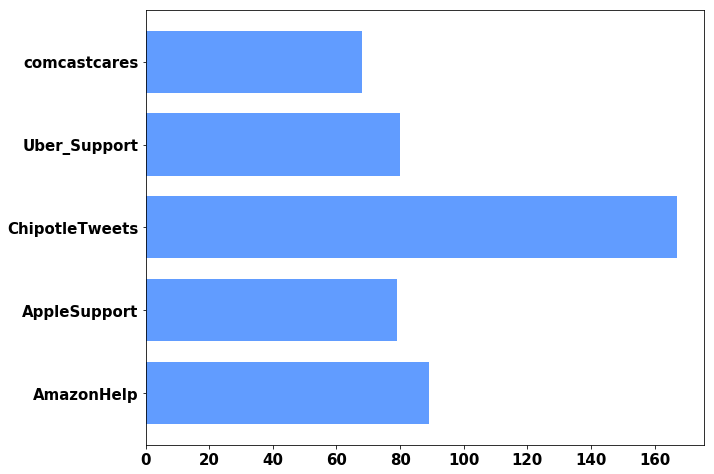

In [25]:
count = QnR.groupby("author_id_y")["text_x"].count()
c = count[count>50].plot(kind='barh',figsize=(10, 8), color='#619CFF', zorder=2, width=width,)
c.set_ylabel('')
plt.show()

In [26]:
airlinesQnR = QnR[(QnR["author_id_y"]=="AmericanAir")|(QnR["author_id_y"]=="British_Airways")]
airlinesQnR.head(4)

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y
128,115892,Tue Oct 31 16:08:21 +0000 2017,Hi @British_Airways! My flight from MAN--LHR--...,British_Airways,Tue Oct 31 22:28:36 +0000 2017,caused. We're unable to offer a complimentary...
129,115893,Tue Oct 31 16:47:55 +0000 2017,@British_Airways will you ever address my com...,British_Airways,Tue Oct 31 22:26:11 +0000 2017,email address and contact telephone number. W...
130,115895,Tue Oct 31 16:05:25 +0000 2017,@British_Airways can I just confirm the email ...,British_Airways,Tue Oct 31 22:23:02 +0000 2017,"Hi Sam, that is the correct email. ^Helen"
131,115896,Tue Oct 31 15:53:10 +0000 2017,@British_Airways runway is under maintenance a...,British_Airways,Tue Oct 31 22:20:23 +0000 2017,"Hi Sreejit, we have no info about this as yet..."


In [27]:
airlinesQnR["text_y"] = airlinesQnR["text_y"].str.lower()  
stop = stopwords.words('english')
big_regex = re.compile(' | '.join(stop))
airlinesQnR["text_y"].progress_apply(lambda x: big_regex.sub(" ",x))

128      caused. we're unable offer complimentary upgr...
129      email address contact telephone number. we'll...
130                       h sam, is correct email. ^helen
131      h sreejit, have info this yet. please keep ey...
132      h david, confirmation emails take to 24 hrs. ...
139      aww, that's definitely future pilot the makin...
140      is great option customers want share miles it...
141      always pleasure have on board, john. a wonder...
142      pilots, potter, pumpkins skeletons...oh my! t...
143      we're glad got kick back enjoy show flying! t...
344      accept apologies. need be fair everyone has u...
345      ask you wish any help questions. we're 24/7 w...
346      we're disappointed hear stephen. there someth...
353      never want experience be anything less perfec...
354      thanks the shout-out for stopping by, marc! w...
355      we're sorry any difficulties you've experienc...
356      always want take care your bags. we're able f...
357        we'

In [28]:
import scattertext as st
nlp = spacy.load('en_core_web_sm',disable_pipes=["tagger","ner"])
airlinesQnR['parsed'] = airlinesQnR.text_y.progress_apply(nlp)

In [29]:
corpus = st.CorpusFromParsedDocuments(airlinesQnR,
                             category_col='author_id_y',
                             parsed_col='parsed').build()

In [30]:
html = st.produce_scattertext_explorer(corpus,
          category='British_Airways',
          category_name='British Airways',
          not_category_name='American Airlines',
          width_in_pixels=600,
          minimum_term_frequency=10,
          term_significance = st.LogOddsRatioUninformativeDirichletPrior(),
          )

c:\python36\lib\site-packages\scattertext\frequencyreaders\DefaultBackgroundFrequencies.py:30: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  names=['word', 'background'])


In [31]:

filename = "americanAir-vs-britishAirways.html"
open(filename, 'wb').write(html.encode('utf-8'))
IFrame(src=filename, width = 800, height=700)

In [32]:
feat_builder = st.FeatsFromOnlyEmpath()
empath_corpus = st.CorpusFromParsedDocuments(airlinesQnR,
                                              category_col='author_id_y',
                                              feats_from_spacy_doc=feat_builder,
                                              parsed_col='parsed').build()

In [33]:
html = st.produce_scattertext_explorer(empath_corpus,
                                        category='British_Airways',
                                        category_name='British Airways',
                                        not_category_name='American Airlines',
                                        width_in_pixels=700,
                                        metadata=airlinesQnR['author_id_y'],
                                        use_non_text_features=True,
                                        use_full_doc=True,
                                        topic_model_term_lists=feat_builder.get_top_model_term_lists())

In [34]:
filename = "empath-BA-vs-AA.html"
open(filename, 'wb').write(html.encode('utf-8'))
IFrame(src=filename, width = 900, height=700)

In [45]:
corpus = (st.CorpusFromParsedDocuments(airlinesQnR,
                             category_col='author_id_y',
                             parsed_col='parsed').build().get_stoplisted_unigram_corpus())

In [46]:
target_term = 'delay'
html = st.word_similarity_explorer(corpus,
                                   category='British_Airways',
                                   category_name='British Airways',
                                   not_category_name='American Airlines',
                                   target_term=target_term,
                                   minimum_term_frequency=5,
                                   width_in_pixels=800)

OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [48]:
file_name = 'similarity.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1000, height=700)

In [49]:
analyser = SentimentIntensityAnalyzer()
text = "you are nice"
score1= analyser.polarity_scores(text)
score=sent_analyser.polarity_scores(text)["compound"]
print("text sentiment : ",sent_analyser.polarity_scores(text)["compound"])
print(score1)





text sentiment :  0.4215
{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.4215}


In [1]:
amazonQnR = QnR[QnR["author_id_y"]=="AmazonHelp"]

NameError: name 'QnR' is not defined

In [94]:
def sentiment(text):
       return (sent_analyser.polarity_scores(text)["compound"] + TextBlob(text).sentiment.polarity)/2
amazonQnR["text_x_sentiment"] = amazonQnR["text_x"].apply(sentiment)
response_emojis_for_positive_queries = []
response_emojis_for_negative_queries = [] 
for i,sentiment in enumerate(amazonQnR["text_x_sentiment"]):
    if sentiment > 0.0:
        response_emojis_for_positive_queries.append(sentiment)
    elif sentiment < 0.0:
        response_emojis_for_negative_queries.append(sentiment)


In [101]:
britishQnR = QnR[QnR["author_id_y"]=="British_Airways"]

In [103]:

def sentiment(text):
       return (sent_analyser.polarity_scores(text)["compound"] + TextBlob(text).sentiment.polarity)/2
britishQnR["text_x_sentiment"] = britishQnR["text_x"].apply(sentiment)
response_emojis_for_positive_queries1 = []
response_emojis_for_negative_queries1 = [] 
for i,sentiment in enumerate(amazonQnR["text_x_sentiment"]):
    if sentiment > 0.0:
        response_emojis_for_positive_queries1.append(sentiment)
    elif sentiment < 0.0:
        response_emojis_for_negative_queries1.append(sentiment)



In [126]:

c1=len(response_emojis_for_negative_queries)
c2=len(response_emojis_for_positive_queries)

c3=len(response_emojis_for_negative_queries1)
c4=len(response_emojis_for_positive_queries1)
print(c1,c2)



34 30


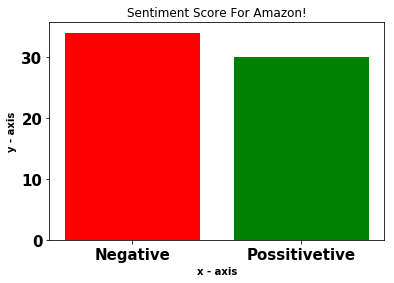

In [123]:
import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
x = ["Negative","Possitive"] 

y=[c1,c2]

  
# labels for bars 

# plotting a bar chart 
plt.bar(x, y, 
        width = 0.8, color = ['red', 'green']) 

  
# naming the x-axis 
plt.xlabel('x - axis') 
# naming the y-axis 
plt.ylabel('y - axis') 
# plot title 
plt.title('Sentiment Score For Amazon!') 
  
# function to show the plot 
plt.show() 